In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import UnidentifiedImageError, ImageFile, ImageEnhance ,Image

In [3]:

# Enable loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load the CSV file
csv_file = './archive/df.csv'
df = pd.read_csv(csv_file)

# Define image directory and image size
image_dir = './archive/images/'
preprocessed_dir = './archive/preprocessed_images'
img_size = (224, 224)

Image Preprocessing

In [4]:
# Create directory for preprocessed images if it doesn't exist
if not os.path.exists(preprocessed_dir):
    os.makedirs(preprocessed_dir)

# Image Data Generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,             # Reduce rotation range
    width_shift_range=0.1,         # Reduce shift range
    height_shift_range=0.1,        # Reduce shift range
    zoom_range=0.1,                # Reduce zoom range
    horizontal_flip=True,          # Keep horizontal flip
    fill_mode='nearest'            # Filling new pixels after augmentation
)

# Function to preprocess and augment images
def preprocess_image(image_path):
    try:
        img = load_img(image_path, target_size=img_size, color_mode='rgb')  # Ensure RGB mode
        img_array = img_to_array(img)                                       # Convert image to array
        img_array /= 255.0                                                 # Normalize pixels to [0, 1]
        img_array = np.expand_dims(img_array, axis=0)                      # Add batch dimension
        
        augmented_img_iter = datagen.flow(img_array, batch_size=1)         # Apply augmentations
        augmented_img = next(augmented_img_iter)[0]                        # Get the augmented image

        # Apply Gaussian Blur directly using OpenCV on normalized image
        augmented_img = cv2.GaussianBlur(augmented_img, (5, 5), 0)

        # Enhance color using PIL
        pil_img = Image.fromarray((augmented_img * 255).astype(np.uint8))  # Convert to uint8
        enhancer = ImageEnhance.Color(pil_img)
        color_enhanced_img = enhancer.enhance(1.5)  # Increase the factor to enhance more

        return color_enhanced_img
    
    except UnidentifiedImageError:
        print(f"Unidentified or corrupted image file: {image_path}")
        return None
    except OSError as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Example: Preprocess and augment images
for idx, row in df.iterrows():
    image_name = row['name']
    image_path = os.path.join(image_dir, image_name)
    
    if os.path.exists(image_path):
        preprocessed_img = preprocess_image(image_path)
        if preprocessed_img is not None:
            # Save enhanced images to a new directory
            enhanced_img_path = os.path.join(preprocessed_dir, f'{image_name}')
            preprocessed_img.save(enhanced_img_path)

print(f"Data preprocessing and augmentation complete! Enhanced images saved to {preprocessed_dir}")


Unidentified or corrupted image file: ./archive/images/000030_1_000030_NONE_29.jpg
Unidentified or corrupted image file: ./archive/images/007790_1_005591_NONE_27.jpg
Data preprocessing and augmentation complete! Enhanced images saved to ./archive/preprocessed_images


DataSet Split in Train Validaiton and Test

In [15]:
import os
import shutil
import pandas as pd
import numpy as np

# Path to the CSV file and image directory
csv_file = './archive/df.csv'
image_dir = './archive/preprocessed_images/'
data_dir = 'Splited_dataset'  # This is where train, valid, test folders will be created

# Read the CSV file
df = pd.read_csv(csv_file)

# Define splits: 70% train, 20% validation, 10% test
split_train = 0.7
split_val = 0.2
split_test = 0.1

# Creating directories for the splits
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

for directory in [train_dir, valid_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to split data and move files
def split_and_move_files(df, class_label, label_name):
    # Filter dataframe for each class
    class_df = df[df['TYPE'] == class_label]
    
    # Shuffle the dataframe
    class_df = class_df.sample(frac=1).reset_index(drop=True)
    
    # Calculate split indices
    idx_train = int(len(class_df) * split_train)
    idx_val = int(len(class_df) * (split_train + split_val))
    
    # Training files
    train_files = class_df.iloc[:idx_train]['name'].tolist()
    # Validation files
    val_files = class_df.iloc[idx_train:idx_val]['name'].tolist()
    # Test files
    test_files = class_df.iloc[idx_val:]['name'].tolist()
    
    # Copy files to respective directories
    for file in train_files:
        src_path = os.path.join(image_dir, file)
        dst_path = os.path.join(train_dir, label_name, file)
        if not os.path.exists(src_path):
            print(f"File not found: {src_path}")  # Debug print
        else:
            shutil.copy(src_path, dst_path)
    for file in val_files:
        src_path = os.path.join(image_dir, file)
        dst_path = os.path.join(valid_dir, label_name, file)
        if not os.path.exists(src_path):
            print(f"File not found: {src_path}")  # Debug print
        else:
            shutil.copy(src_path, dst_path)
    for file in test_files:
        src_path = os.path.join(image_dir, file)
        dst_path = os.path.join(test_dir, label_name, file)
        count = 0
        if not os.path.exists(src_path):
            print(f"File not found: {src_path}")  # Debug print
            count = count + 1
            print(count)
        else:
            shutil.copy(src_path, dst_path)


# Create subdirectories in train, valid, test
labels = {
    1: 'mask_worn_correctly',
    2: 'mask_not_on_nose',
    3: 'mask_on_chin',
    4: 'no_mask'
}

for label, name in labels.items():
    for directory in [train_dir, valid_dir, test_dir]:
        os.makedirs(os.path.join(directory, name), exist_ok=True)
    split_and_move_files(df, label, name)

print("Data successfully structured and split into train, valid, and test sets.")


File not found: ./archive/preprocessed_images/002177_1_002177_NONE_24.jpg
File not found: ./archive/preprocessed_images/003295_1_003295_MALE_21.jpg
File not found: ./archive/preprocessed_images/003721_1_001142_MALE_20.jpg
File not found: ./archive/preprocessed_images/004145_1_003719_NONE_35.jpg
File not found: ./archive/preprocessed_images/003404_1_003404_NONE_27.jpg
File not found: ./archive/preprocessed_images/003378_1_003378_NONE_32.jpg
File not found: ./archive/preprocessed_images/001544_1_001544_MALE_29.jpg
File not found: ./archive/preprocessed_images/004968_1_004167_MALE_19.jpg
File not found: ./archive/preprocessed_images/006974_1_005223_MALE_30.jpg
File not found: ./archive/preprocessed_images/003734_1_000200_MALE_31.jpg
File not found: ./archive/preprocessed_images/005726_1_001353_MALE_29.jpg
File not found: ./archive/preprocessed_images/005257_1_003236_MALE_29.jpg
File not found: ./archive/preprocessed_images/003719_1_003544_NONE_20.jpg
File not found: ./archive/preprocessed

In [5]:
import os
import shutil
import pandas as pd
import numpy as np

# Path to the CSV file and image directory
csv_file = './archive/df.csv'
image_dir = './archive/preprocessed_images/'
data_dir = 'Splited_dataset'  # This is where train and valid folders will be created

# Read the CSV file
df = pd.read_csv(csv_file)

# Define splits: 80% train, 20% validation (no test set)
split_train = 0.8
split_val = 0.2

# Creating directories for the splits
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')

for directory in [train_dir, valid_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to split data and move files
def split_and_move_files(df, class_label, label_name):
    # Filter dataframe for each class
    class_df = df[df['TYPE'] == class_label]
    
    # Shuffle the dataframe
    class_df = class_df.sample(frac=1).reset_index(drop=True)
    
    # Calculate split indices
    idx_train = int(len(class_df) * split_train)
    
    # Training files
    train_files = class_df.iloc[:idx_train]['name'].tolist()
    # Validation files
    val_files = class_df.iloc[idx_train:]['name'].tolist()
    
    # Copy files to respective directories
    for file in train_files:
        src_path = os.path.join(image_dir, file)
        dst_path = os.path.join(train_dir, label_name, file)
        if not os.path.exists(src_path):
            print(f"File not found: {src_path}")  # Debug print
        else:
            shutil.copy(src_path, dst_path)
    for file in val_files:
        src_path = os.path.join(image_dir, file)
        dst_path = os.path.join(valid_dir, label_name, file)
        if not os.path.exists(src_path):
            print(f"File not found: {src_path}")  # Debug print
        else:
            shutil.copy(src_path, dst_path)

# Create subdirectories in train and valid
labels = {
    1: 'mask_worn_correctly',
    2: 'mask_not_on_nose',
    3: 'mask_on_chin',
    4: 'no_mask'
}

for label, name in labels.items():
    for directory in [train_dir, valid_dir]:
        os.makedirs(os.path.join(directory, name), exist_ok=True)
    split_and_move_files(df, label, name)

print("Data successfully structured and split into train and valid sets.")


File not found: ./archive/preprocessed_images/005257_1_003236_MALE_29.jpg
File not found: ./archive/preprocessed_images/007108_1_004732_NONE_19.jpg
File not found: ./archive/preprocessed_images/003666_1_002056_MALE_22.jpg
File not found: ./archive/preprocessed_images/002514_1_002514_NONE_23.jpg
File not found: ./archive/preprocessed_images/002062_1_002062_NONE_22.jpg
File not found: ./archive/preprocessed_images/006974_1_005223_MALE_30.jpg
File not found: ./archive/preprocessed_images/005487_1_004446_FEMALE_29.jpg
File not found: ./archive/preprocessed_images/006548_1_004998_MALE_24.jpg
File not found: ./archive/preprocessed_images/001383_1_001383_MALE_20.jpg
File not found: ./archive/preprocessed_images/006869_1_005163_FEMALE_31.jpg
File not found: ./archive/preprocessed_images/002118_1_002118_FEMALE_28.jpg
File not found: ./archive/preprocessed_images/004353_1_003837_MALE_32.jpg
File not found: ./archive/preprocessed_images/000030_1_000030_NONE_29.jpg
File not found: ./archive/prepro

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image, ImageEnhance
import cv2

# Set parameters
img_size = (224, 224)  # Target image size
image_dir = "./demo_images"  # Replace with your image folder path
preprocessed_dir = "./preprocessed_demo_images"
os.makedirs(preprocessed_dir, exist_ok=True)  # Create directory for preprocessed images

# Data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing function
def preprocess_image(image_path):
    try:
        # Load and normalize the image
        img = load_img(image_path, target_size=img_size, color_mode='rgb')
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Apply data augmentation
        augmented_img_iter = datagen.flow(img_array, batch_size=1)
        augmented_img = next(augmented_img_iter)[0]

        # Apply Gaussian Blur
        blurred_img = cv2.GaussianBlur(augmented_img, (5, 5), 0)

        # Enhance color
        pil_img = Image.fromarray((blurred_img * 255).astype(np.uint8))
        enhancer = ImageEnhance.Color(pil_img)
        color_enhanced_img = enhancer.enhance(1.5)

        return img, augmented_img, color_enhanced_img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None

# Visualize preprocessing on a sample image
sample_image_path = "./demo_images/sample.jpg"  # Replace with your sample image path

if os.path.exists(sample_image_path):
    original_img, augmented_img, enhanced_img = preprocess_image(sample_image_path)

    # Display results
    if original_img is not None:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(original_img)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(augmented_img)
        axs[1].set_title("Augmented + Blurred Image")
        axs[1].axis('off')

        axs[2].imshow(enhanced_img)
        axs[2].set_title("Color Enhanced Image")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()
else:
    print(f"Sample image not found at {sample_image_path}. Please provide a valid image path.")


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/Users/deepanshusehgal/Developer/Code/AI_ML/apple-silicon/.venv/lib/python3.9/site-packages/keras/api/preprocessing/image/__init__.py)

Resnet50 Model Traning

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Image specifications
img_height, img_width = 224, 224  # Size expected by ResNet50
batch_size = 32

# Path to the data directories
train_dir = 'Splited_dataset/train'
valid_dir = 'Splited_dataset/valid'
test_dir = 'Splited_dataset/test'

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for correct prediction results
)

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the convolutional base

# Custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes based on your dataset

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save('mask_detection_model.h5')


Num GPUs Available:  1
Found 36193 images belonging to 4 classes.
Found 14329 images belonging to 4 classes.
Found 7569 images belonging to 4 classes.
Epoch 1/10
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 440s 387ms/step - accuracy: 0.2635 - loss: 1.4455 - val_accuracy: 0.2865 - val_loss: 1.3785
Epoch 2/10
   1/1131 ━━━━━━━━━━━━━━━━━━━━ 5:39 301ms/step - accuracy: 0.0938 - loss: 1.4079

2024-09-22 19:41:24.865452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 19:41:24.865490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_16]]


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - accuracy: 0.0938 - loss: 1.4079 - val_accuracy: 0.4800 - val_loss: 1.3454
Epoch 3/10


2024-09-22 19:41:25.592492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 19:41:25.592510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 474s 419ms/step - accuracy: 0.2682 - loss: 1.3808 - val_accuracy: 0.2926 - val_loss: 1.3777
Epoch 4/10
   1/1131 ━━━━━━━━━━━━━━━━━━━━ 5:37 298ms/step - accuracy: 0.3125 - loss: 1.3777

2024-09-22 19:49:19.856022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 19:49:19.856056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_16]]


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step - accuracy: 0.3125 - loss: 1.3777 - val_accuracy: 0.2400 - val_loss: 1.3978
Epoch 5/10


2024-09-22 19:49:20.144314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 19:49:20.144362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 460s 407ms/step - accuracy: 0.2768 - loss: 1.3780 - val_accuracy: 0.3096 - val_loss: 1.3714
Epoch 6/10
   1/1131 ━━━━━━━━━━━━━━━━━━━━ 5:26 289ms/step - accuracy: 0.1875 - loss: 1.3790

2024-09-22 19:57:00.564634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 19:57:00.564660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_16]]


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 303us/step - accuracy: 0.1875 - loss: 1.3790 - val_accuracy: 0.1200 - val_loss: 1.4045
Epoch 7/10


2024-09-22 19:57:00.869248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 19:57:00.869289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 455s 402ms/step - accuracy: 0.2766 - loss: 1.3774 - val_accuracy: 0.3157 - val_loss: 1.3641
Epoch 8/10
   1/1131 ━━━━━━━━━━━━━━━━━━━━ 5:31 293ms/step - accuracy: 0.1875 - loss: 1.3958

2024-09-22 20:04:35.988018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 20:04:35.988043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_16]]


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 285us/step - accuracy: 0.1875 - loss: 1.3958 - val_accuracy: 0.1600 - val_loss: 1.3886
Epoch 9/10


2024-09-22 20:04:36.275213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 20:04:36.275249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 474s 419ms/step - accuracy: 0.2826 - loss: 1.3741 - val_accuracy: 0.3291 - val_loss: 1.3637
Epoch 10/10
   1/1131 ━━━━━━━━━━━━━━━━━━━━ 5:45 306ms/step - accuracy: 0.1875 - loss: 1.4266

2024-09-22 20:12:30.417259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 20:12:30.417296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_16]]


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 332us/step - accuracy: 0.1875 - loss: 1.4266 - val_accuracy: 0.3600 - val_loss: 1.3744


2024-09-22 20:12:30.748441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-22 20:12:30.748480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 308ms/step - accuracy: 0.2580 - loss: 1.3625


Test Loss: 1.3632302284240723, Test Accuracy: 0.3313515782356262


MobileNetV2 Model Traning

Found 36193 images belonging to 4 classes.
Found 14329 images belonging to 4 classes.
Found 7569 images belonging to 4 classes.
Epoch 1/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 278s 243ms/step - accuracy: 0.6824 - loss: 0.8065 - val_accuracy: 0.8172 - val_loss: 0.4501 - learning_rate: 0.0010
Epoch 2/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 303s 267ms/step - accuracy: 0.7704 - loss: 0.5558 - val_accuracy: 0.8263 - val_loss: 0.4335 - learning_rate: 0.0010
Epoch 3/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 282s 248ms/step - accuracy: 0.7715 - loss: 0.5437 - val_accuracy: 0.8218 - val_loss: 0.4387 - learning_rate: 0.0010
Epoch 4/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 278s 244ms/step - accuracy: 0.7818 - loss: 0.5252 - val_accuracy: 0.8337 - val_loss: 0.4121 - learning_rate: 0.0010
Epoch 5/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 297s 261ms/step - accuracy: 0.7894 - loss: 0.5109 - val_accuracy: 0.8433 - val_loss: 0.3909 - learning_rate: 0.0010
Epoch 6/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 294s 259ms/step - accuracy: 0.7917 - los

Test Loss: 0.3290914297103882, Test Accuracy: 0.8699960112571716


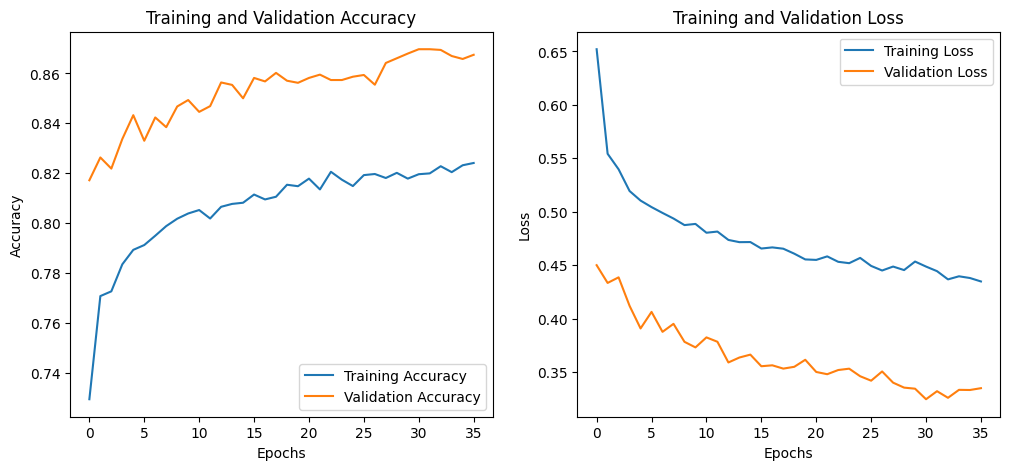

In [34]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Paths to dataset directories
train_dir = 'Splited_dataset/train'
valid_dir = 'Splited_dataset/valid'
test_dir = 'Splited_dataset/test'

# Data generators for training, validation, and test
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

# Load MobileNetV2 without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes for mask classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_mask_detection_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)

# Train the model and store the history
history = model.fit(
    train_generator,
    epochs=50,  # Increased epochs
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the final model in .h5 format
model.save('final_mask_detection_model.h5')

# Plot training & validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot accuracy and loss
plot_training_history(history)


ResNet50 Traning and Loss Graph

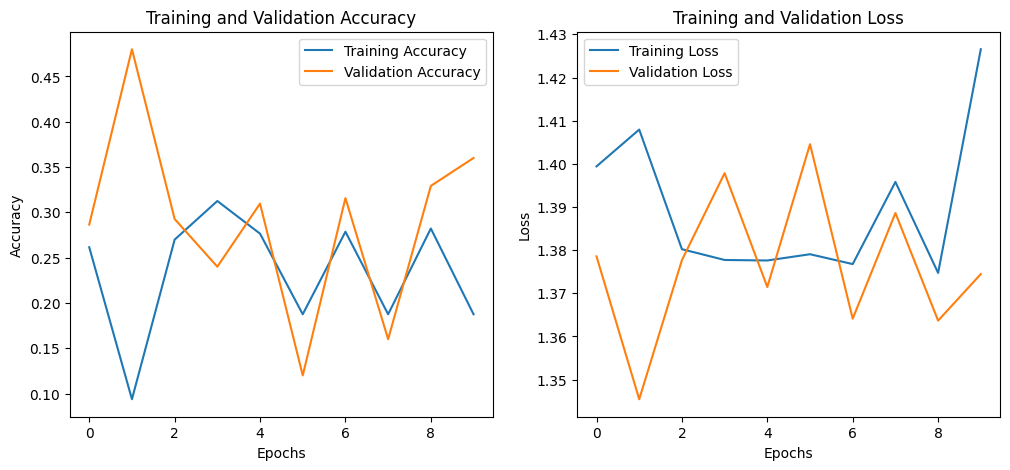

In [31]:

# Plot training & validation accuracy and loss
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot accuracy and loss
plot_training_history(history)

In [3]:
# -*- coding: utf-8 -*-

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
import argparse
import os
from tensorflow.keras.applications import ResNet50V2

ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True,
	help="path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png",
	help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to output face mask detector model")
args = vars(ap.parse_args())

print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

IMG_SIZE = 224
CHANNELS = 3
N_LABELS=2


# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
  image = load_img(imagePath, target_size=(IMG_SIZE, IMG_SIZE))
  image = img_to_array(image)
  image = image/255
#image = preprocess_input(image)

	# update the data and labels lists, respectively
  data.append(image)
  labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


feature_extractor_layer = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(IMG_SIZE,IMG_SIZE,CHANNELS)))

feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Flatten(name="flatten"),
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dropout(0.5),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 20
BS = 256

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss="binary_crossentropy",
  metrics=["accuracy"])

import time
start = time.time()
history = model.fit(aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	epochs=EPOCHS)
print('\nTraining took {}'.format((time.time()-start)))

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])


ModuleNotFoundError: No module named 'tensorflow_hub'

Num GPUs Available:  1
Found 36193 images belonging to 4 classes.
Found 14329 images belonging to 4 classes.
Found 7569 images belonging to 4 classes.
Epoch 1/5


/Users/deepanshusehgal/Developer/Code/AI_ML/apple-silicon/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 439s 384ms/step - accuracy: 0.3397 - loss: 1.4330 - val_accuracy: 0.6369 - val_loss: 0.8973
Epoch 2/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 510s 450ms/step - accuracy: 0.5387 - loss: 1.0203 - val_accuracy: 0.7014 - val_loss: 0.7435
Epoch 3/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 550s 485ms/step - accuracy: 0.6029 - loss: 0.8950 - val_accuracy: 0.7288 - val_loss: 0.6678
Epoch 4/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 553s 488ms/step - accuracy: 0.6291 - loss: 0.8350 - val_accuracy: 0.7428 - val_loss: 0.6268
Epoch 5/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 589s 520ms/step - accuracy: 0.6616 - loss: 0.7750 - val_accuracy: 0.7550 - val_loss: 0.6002
237/237 ━━━━━━━━━━━━━━━━━━━━ 75s 316ms/step - accuracy: 0.6769 - loss: 0.7075


Test Loss: 0.6017346382141113, Test Accuracy: 0.7546571493148804


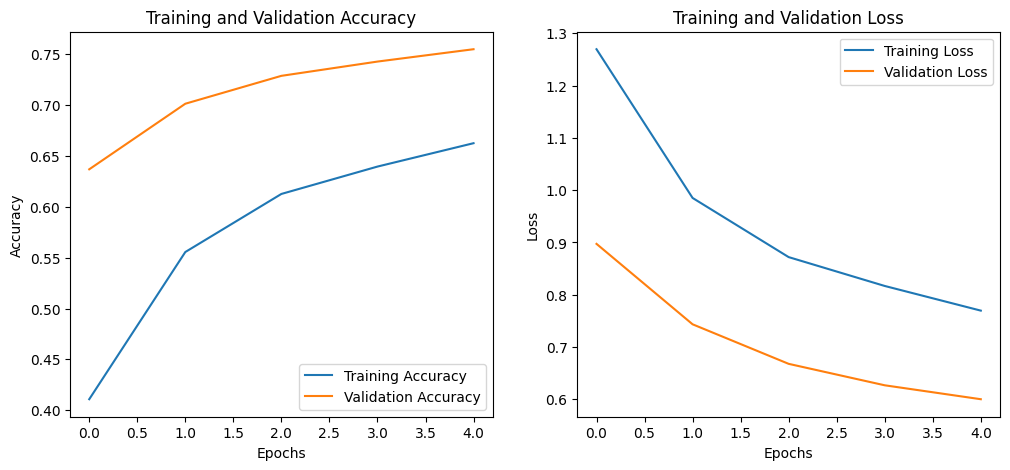

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Global variable for number of epochs
EPOCHS = 5  # Set to 5 for now, you can adjust this later

# Image specifications
img_height, img_width = 224, 224  # Size expected by ResNet50V2
batch_size = 32

# Path to the data directories
train_dir = 'Splited_dataset/train'
valid_dir = 'Splited_dataset/valid'
test_dir = 'Splited_dataset/test'

# Data augmentation for training, and rescaling for validation and testing datasets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for correct prediction results
)

# Calculate correct steps_per_epoch and validation_steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Load the ResNet50V2 model pre-trained on ImageNet
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the convolutional base


# model_resnet = Sequential()
# model_resnet.add(base_model)
# model_resnet.add(GlobalAveragePooling2D())
# model_resnet.add(Dense(1024,activation='relu'))
# Add custom layers on top of ResNet50V2
x= Sequential()
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes based on your dataset

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a smaller learning rate for transfer learning
LR = 1e-5  # Learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_mask_detection_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train the model
history = model.fit(
    train_generator,
    # steps_per_epoch=steps_per_epoch,  # Use correct steps
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1,  # Added verbosity for detailed output
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the final model
model.save('final_mask_detection_model.h5')

# Plot training & validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot accuracy and loss
plot_training_history(history)


Found 36193 images belonging to 4 classes.
Found 14329 images belonging to 4 classes.
Found 7569 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 882s 778ms/step - accuracy: 0.4029 - loss: 1.2663 - val_accuracy: 0.6510 - val_loss: 0.8966 - learning_rate: 1.0000e-04
Epoch 2/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 1014s 895ms/step - accuracy: 0.6154 - loss: 0.9217 - val_accuracy: 0.7033 - val_loss: 0.7618 - learning_rate: 1.0000e-04
Epoch 3/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 1077s 951ms/step - accuracy: 0.6646 - loss: 0.8172 - val_accuracy: 0.7292 - val_loss: 0.6944 - learning_rate: 1.0000e-04
Epoch 4/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 1164s 1s/step - accuracy: 0.6881 - loss: 0.7575 - val_accuracy: 0.7404 - val_loss: 0.6712 - learning_rate: 1.0000e-04
Epoch 5/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 1812s 2s/step - accuracy: 0.6976 - loss: 0.7303 - val_accuracy: 0.7538 - val_loss: 0.6328 - learning_rate: 1.0000e-04
237/237 ━━━━━━━━━━

Test Loss: 0.6203534603118896, Test Accuracy: 0.7510899901390076


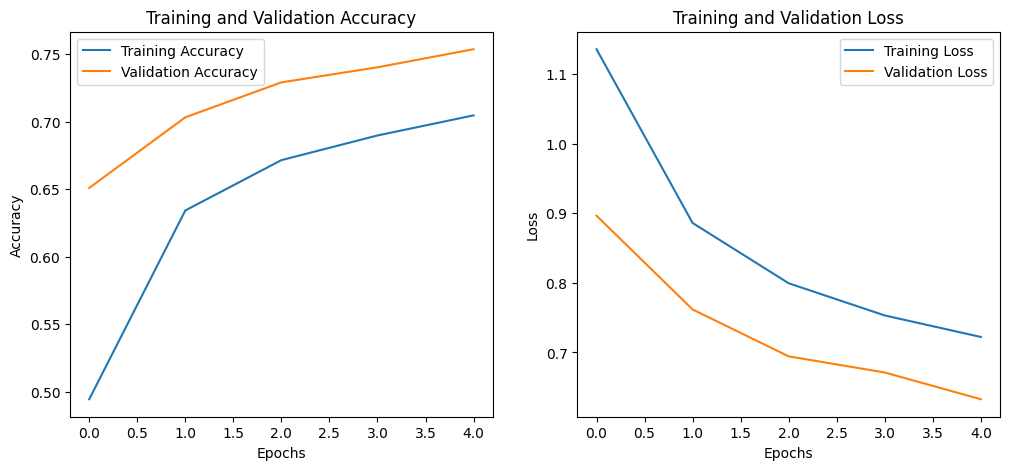

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Global variable for the number of epochs
EPOCHS = 5  # Set to 5

# Paths to dataset directories
train_dir = 'Splited_dataset/train'
valid_dir = 'Splited_dataset/valid'
test_dir = 'Splited_dataset/test'

# Data generators for training, validation, and test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes for mask classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
LR = 1e-4  # Reduced learning rate for VGG16
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_vgg16_mask_detection_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001, verbose=1)

# Train the model and store the history
history = model.fit(
    train_generator,
    epochs=EPOCHS,  # Use global EPOCHS variable here
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the final model in .h5 format
model.save('final_vgg16_mask_detection_model.h5')

# Plot training & validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot accuracy and loss
plot_training_history(history)


Found 36193 images belonging to 4 classes.
Found 14329 images belonging to 4 classes.
Found 7569 images belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Epoch 1/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 662s 581ms/step - accuracy: 0.6292 - loss: 0.8529 - val_accuracy: 0.7799 - val_loss: 0.5426 - learning_rate: 1.0000e-04
Epoch 2/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 717s 632ms/step - accuracy: 0.7518 - loss: 0.5935 - val_accuracy: 0.7963 - val_loss: 0.4980 - learning_rate: 1.0000e-04
Epoch 3/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 698s 616ms/step - accuracy: 0.7669 - loss: 0.5579 - val_accuracy: 0.8049 - val_loss: 0.4794 - learning_rate: 1.0000e-04
Epoch 4/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 678s 598ms/step - accuracy: 0.7732 - loss: 0.5390 - val_accuracy: 0.8089 - val_loss: 0.4637 - learning_rate: 1.0000e-04
Epoch 5/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 681s 600ms/step - accuracy: 0.7856 - loss: 0.5170 - val_accuracy: 0.8166 - val_loss: 0.4478 - learning_rate: 1.0000e-04
237/237 ━━━━━━━━

Test Loss: 0.44240862131118774, Test Accuracy: 0.8170167803764343


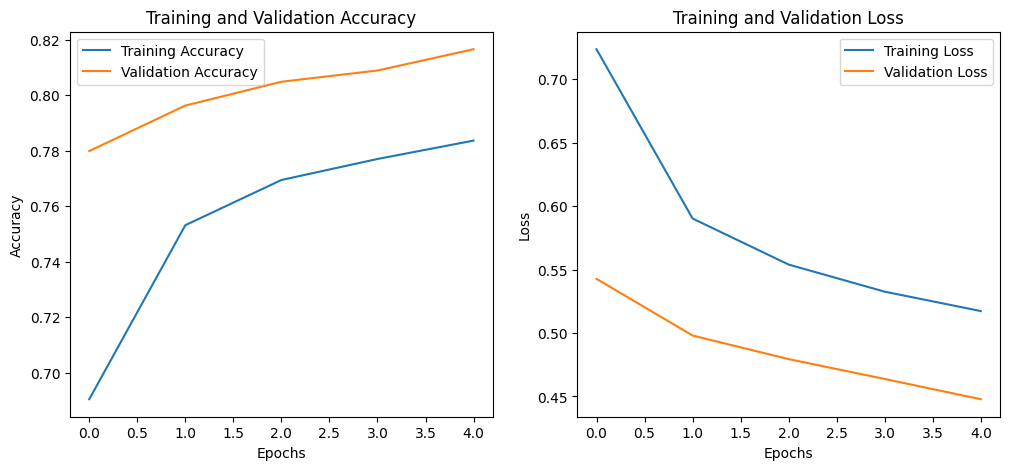

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Global variable for the number of epochs
EPOCHS = 5  # Set to 5

# Paths to dataset directories
train_dir = 'Splited_dataset/train'
valid_dir = 'Splited_dataset/valid'
test_dir = 'Splited_dataset/test'

# Data generators for training, validation, and test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # InceptionV3 expects input images of size 299x299
    batch_size=32,
    class_mode='categorical'
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(299, 299),  # InceptionV3 expects input images of size 299x299
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),  # InceptionV3 expects input images of size 299x299
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes for mask classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
LR = 1e-4  # Reduced learning rate for transfer learning with InceptionV3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_inceptionv3_mask_detection_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001, verbose=1)

# Train the model and store the history
history = model.fit(
    train_generator,
    epochs=EPOCHS,  # Use global EPOCHS variable here
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the final model in .h5 format
model.save('final_inceptionv3_mask_detection_model.h5')

# Plot training & validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot accuracy and loss
plot_training_history(history)
